# Scikit-Learn Test Notebook

* Import tests from the corresponding test_sklearn.py
* Develoop and Debub Tests

# Imports

In [1]:
# sforecast
import sforecast as sf
print(f'sforecast version = {sf.__version__}')

# python - pandas
import pandas as pd
import numpy as np
from datetime import datetime

# scikit-learn
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

# plotting
import beautifulplots as bp
import matplotlib.pyplot as plt

import matplotlib
from pandas.plotting import autocorrelation_plot

2024-07-24 05:20:39.066500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


sforecast version = 0.6.3


# Data

superstore

In [2]:
#### data Superstore
df_sales = pd.read_csv("../data/Superstore_subcatsales_2017_cdp.csv", parse_dates = ["Order Date"])
aggs = {
    "Sales":"sum",
    "Quantity":"sum"  
}

##### aggregate to category sales
df_catsales = df_sales.groupby(["Order Date" , "Category"]).agg(aggs).reset_index()

display(df_catsales.head())


,Order Date,Category,Sales,Quantity
0,2014-01-03,Office Supplies,16.448,2.0
1,2014-01-04,Office Supplies,288.060,8.0
2,2014-01-05,Office Supplies,19.536,3.0
3,2014-01-06,Furniture,2573.820,9.0
4,2014-01-06,Office Supplies,685.340,15.0


wide format

In [3]:
dfXYw = df_catsales.copy()

def to_flat_columns(hier_cols):
    flat_cols=[]
    for clist in hier_cols:
        for n,ci in enumerate(clist):
            c = ci if n == 0 else c+"_"+ci 
        flat_cols.append(c)
    return flat_cols


dp = "Order Date" # demand period
dfXYw = dfXYw.pivot(index=dp, columns = "Category" , values = ["Quantity" , "Sales"] )
flat_cols = to_flat_columns(dfXYw.columns)
dfXYw.columns = flat_cols 
dfXYw = dfXYw.fillna(0)
display(dfXYw.head())

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Sales_Furniture,Sales_Office Supplies,Sales_Technology
Order Date,,,,,,
2014-01-03,0.0,2.0,0.0,0.000,16.448,0.00
2014-01-04,0.0,8.0,0.0,0.000,288.060,0.00
2014-01-05,0.0,3.0,0.0,0.000,19.536,0.00
2014-01-06,9.0,15.0,6.0,2573.820,685.340,1147.94
2014-01-07,3.0,7.0,0.0,76.728,10.430,0.00


# Test Univariate

univariate fit ... does not include predict

visualize the test vs predicted/fit output below

In [4]:
from test_sklearn import test_univariate

df_pred_uv = test_univariate()

display(df_pred_uv)



/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])
/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,dfnewrows])
/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:245: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is depreca

,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,
2014-01-03,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2017-12-26,NaN,0.0,12.570740,12.570740,0.0,20.869277
2017-12-27,NaN,0.0,4.480949,4.480949,0.0,12.779486
2017-12-28,NaN,17.0,13.771085,-3.228915,0.0,22.069622


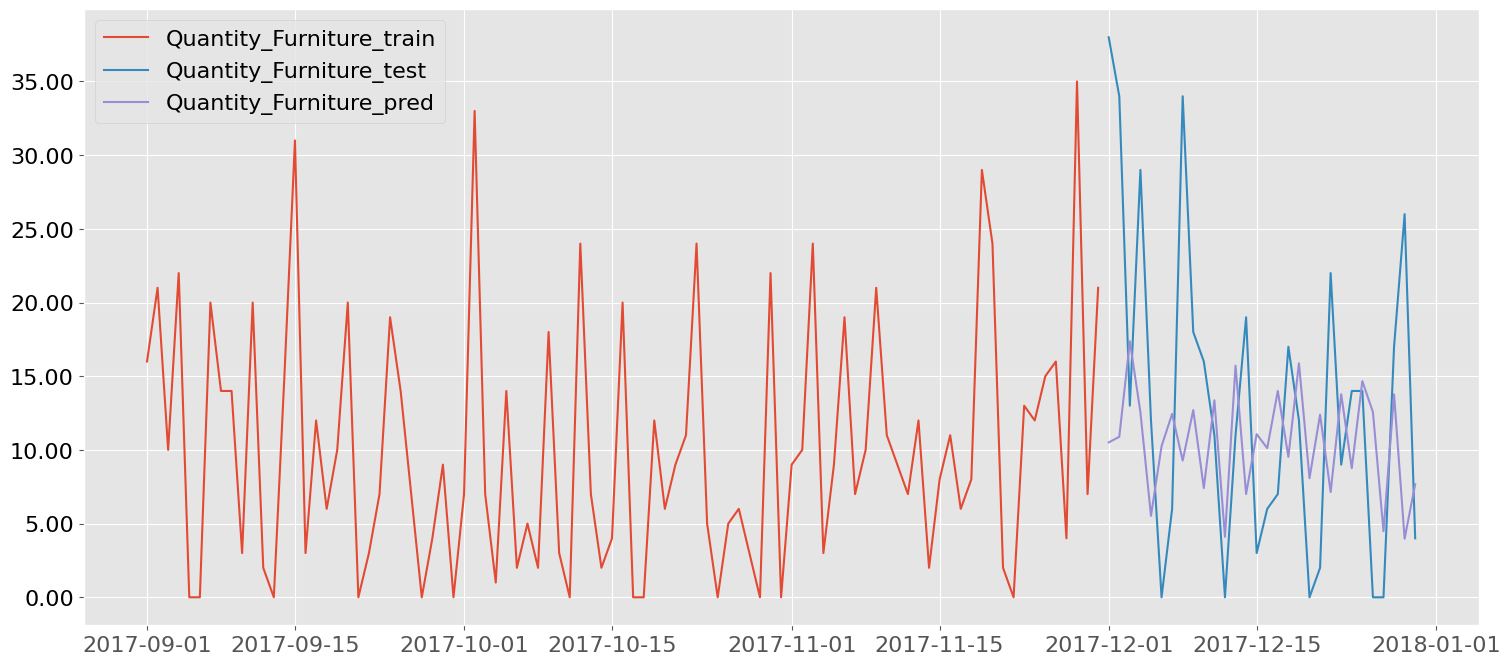

In [5]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfxgbuv = df_pred_uv.reset_index().copy() # seaborn lineplot function needs x-axis to be a column

d=datetime(2017,9,1)
bp.lineplot(dfxgbuv[dfxgbuv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8) , legend=True)

# XGB Regression Multivariate Exog Endog

In [6]:
from test_sklearn import test_multivariate_exog_endog_mout

df_pred_xgbmv = test_multivariate_exog_endog_mout()

display(df_pred_xgbmv)

/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:198: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfXY[cv_shift_vars] = dfXY[covars].shift(n)
/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:198: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfXY[cv_shift_vars] = dfXY[covars].shift(n)
/Users/albertogutierrez/workspaces/sforecast/src/sforecast/sliding_forecast.py:198: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

ypred = Quantity_Furniture_pred
ypred Quantity_Furniture = [10.13771915 21.13952827 10.06799603 13.57469654  5.1327486  10.20585251
 16.38446426 10.94353294 12.48682308 10.56077671  9.82081223 10.75837994
  3.26499557 14.57682228 18.00475121 17.08892632 10.30344677  9.99220085
 11.69583416  7.8512516   5.80593872  8.7285862   9.46153259  8.81838322
 11.31271648  9.11960983  7.24981451 14.95108986 18.49375153  8.23642826]
y = ['Quantity_Furniture', 'Quantity_Office Supplies', 'Quantity_Technology']
Quantity_Furniture_pred
pred_result = [10.13771915435791, 21.139528274536133, 10.06799602508545, 13.57469654083252, 5.132748603820801, 10.205852508544922, 16.384464263916016, 10.943532943725586, 12.486823081970215, 10.560776710510254, 9.820812225341797, 10.758379936218262, 3.264995574951172, 14.576822280883789, 18.004751205444336, 17.088926315307617, 10.303446769714355, 9.99220085144043, 11.695834159851074, 7.851251602172852, 5.805938720703125, 8.728586196899414, 9.461532592773438, 8.81838321

,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper,Quantity_Office Supplies_train,Quantity_Office Supplies_test,Quantity_Office Supplies_pred,Quantity_Office Supplies_pred_error,Quantity_Office Supplies_pred_lower,Quantity_Office Supplies_pred_upper,Quantity_Technology_train,Quantity_Technology_test,Quantity_Technology_pred,Quantity_Technology_pred_error,Quantity_Technology_pred_lower,Quantity_Technology_pred_upper
Order Date,,,,,,,,,,,,,,,,,,
2014-01-03,0.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,NaN,0.0,9.119610,9.119610,0.000000,19.766999,NaN,12.0,12.326706,0.326706,0.000000,18.121150,NaN,0.0,3.842882,3.842882,0.000000,13.018852
2017-12-27,NaN,0.0,7.249815,7.249815,0.000000,17.821237,NaN,4.0,5.972883,1.972883,0.000000,25.486921,NaN,2.0,5.939587,3.939587,0.000000,18.639607
2017-12-28,NaN,17.0,14.951090,-2.048910,0.000000,14.157401,NaN,44.0,33.685150,-10.314850,0.000000,26.331535,NaN,3.0,9.177584,6.177584,5.746384,14.851728
